# Problem 1.3: Baseball Exit Velocities

This notebook uses to the matrices you derived in questions 1.1 and 1.2 of this problem set to characterize the posterior distribution over the initial height and and vertical velocity of a baseball after it has been hit.

## Coding Tasks
There 5 `TODO` comments labeled in the code below.
1. Write code to construct the matrix $A$ from question 1.1.
2. Write code to construct the vector $b$ from question 1.1.
3. Use numpy's matrix multiplication and addition tools to construct the marginal covariance of the observation vector $\mathbf{z}$.
4. Construct the cross covariance of $\mathbf{z}$ and $x=[z_0,v_0]$.
5. Use numpy's linalg package to compute the posterior covariance. (Note that you can adapt what's already in this notebook for computing the posterior mean).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def CreateObservationOperator(times):
    """ Constructs the matrix A and vector b from problem 1.1
    
        ARGS:
            times (np.array): A numpy vector of length N containing the observations times t_1,...,t_N
        
        RETURNS:
            A
    """
    N = times.shape[0] # The number of observation times
    
    # TODO 1: Write code to fill the contents of A with your solution from part 1
    A = np.ones((N,2))
    A[:,1] = times
    
    # TODO 2: Write code to fill the contents of b with your solution from part 1
    g = 9.81
    b = -0.5*g*times*times
    
    return A, b

def ComputeCovariances(A, sigma_xx, sigma_eps):
    """
    This function uses the matrix returned by the ObservationOperator function
    to compute the cross covariance between the initial conditions [z_0,v_0] 
    and the observable elevations $\mathbf{z}$.  
    
    ARGS:
        A (np.array): An Nx2 matrix derived from the parabolic model for projectile motion.
        sigma_xx (np.array): A 2x2 matrix containing the prior covariance of the initial conditions.
        sigma_eps (float): A single number for the observation variables $\sigma_\epsilon^2$
        
    RETURNS:
        sigma_zz (np.array): An NxN matrix containing the marginal covariance of the observable elevations.
        sigma_zx (np.array): An Nx2 matrix containing the cross covariance between the observable elevations and the initial conditions.
    """
    N = A.shape[0]
    
    # TODO 3: Overwrite the matrix sigma_zz with the actual marginal covariance from part 2 of this question
    sigma_zz = A@sigma_xx@A.T + sigma_eps*np.eye(N)
    
    # TODO 4: Overwrite the matrix sigma_zx with the cross covariance you computed in part 2
    sigma_zx = A@sigma_xx
    
    return sigma_zz, sigma_zx

def GetPrior():
    """ Returns the two-dimensional prior mean vector and the 2x2 prior covariance matrix.
    """
    
    mu = np.array([0.5, 30.0])
    
    cov = np.array([[0.125, 0.0],
                    [0.0,   100.0]])
    
    return mu, cov


def GetObservations():
    """ Returns the observation times and observed elevations of the baseball. """
 
    obs_times = np.array([0.0, 0.7, 1.4, 2.1, 2.8, 3.5])
    obs_vals = np.array([0.93, 7.43, 19.33, 18.46, 13.10, 5.45])
    
    return obs_times, obs_vals

def ComputePosterior(obs_val, mu_x, mu_y, sigma_xx, sigma_yy, sigma_yx):
    """ For two jointly distribution Gaussian random variables, this function
        computes the posterior mean and covariance of x|y using the marginal
        means mu_x and mu_y, marginal covariances sigma_xx and sigma_yy, as well
        as the cross covariance sigma_yx.
        
        ARGS:
            obs_val (np.array): The observed values of $Y$.
            mu_x (np.array): The mean of X
            mu_y (np.array): The mean of Y
            sigma_xx (np.array): The covariance matrix of X
            sigma_yy (np.array): The covariance matrix of Y
            sigma_yx (np.array): The cross covariance of Y and X.
            
        RETURNS:
            mu (np.array): The posterior mean of x|y
            sigma (np.array): The posterior covariance of x|y
            
    """
    
    # check the input dimensions
    dim_x = mu_x.shape[0]
    dim_y = mu_y.shape[0]
    
    assert((dim_x==sigma_xx.shape[0])&(dim_x==sigma_xx.shape[1]))
    assert((dim_y==sigma_yy.shape[0])&(dim_y==sigma_yy.shape[1]))
    assert((dim_y==sigma_yx.shape[0])&(dim_x==sigma_yx.shape[1]))
    
    # Compute the Kalman gain
    K = np.linalg.solve(sigma_yy, sigma_yx).T
    
    # np.linalg.solve(sigma_yy, sigma_yx).T =  ((sigma_yy)^{-1} * sigma_yx )^T = sigma_yx^T * (sigma_yy)^{-1}
    
    # Compute the posterior mean
    post_mu = mu_x + K@(obs_val - mu_y)
    
    # TODO 5: Replace the following line to compute the posterior covariance
    post_cov = sigma_xx - K@sigma_yx
    
    return post_mu, post_cov
    

### Get the observations and set up the model

In [3]:
obs_var = 3.0
obs_times, obs_elevs = GetObservations()

A, b = CreateObservationOperator(obs_times)

### Set up the joint prior distribution

In [4]:
# first component is initial position, second is initial vertical velocity
mu_x, sigma_xx = GetPrior() 

mu_z = A@mu_x + b

sigma_zz, sigma_zx = ComputeCovariances(A, sigma_xx, obs_var)

### Compute the posterior mean and covariance

In [5]:
post_mu, post_cov = ComputePosterior(obs_elevs, mu_x, mu_z, sigma_xx, sigma_zz, sigma_zx)

### Compute and plot the posterior predictive over the trajectory
Given the posterior distribution of $z_0$ and $v_0$, we can use the fact that a linear transformation of a multivariate Gaussian random variable is another Gaussian random variable to compute the distribution over the baseball's trajectory.

In [6]:
pred_times = np.linspace(0,3.5,100)
pred_A, pred_b = CreateObservationOperator(pred_times)

pred_mean = pred_A@post_mu + pred_b
pred_cov = pred_A@post_cov@pred_A.T + obs_var*np.eye(pred_times.shape[0])

# Extract the standard deviation of the predictions, which is the square root of the diagonal of the prediction covariance
pred_std = np.sqrt(np.diag(pred_cov))

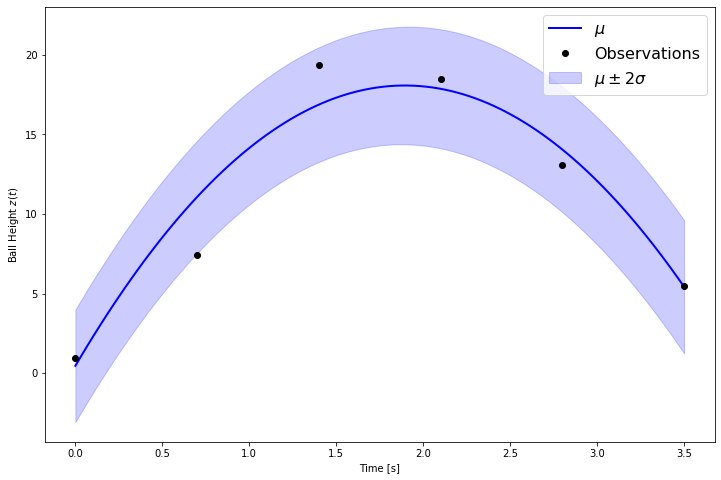

In [7]:
plt.figure(figsize=(12,8))

plt.fill_between(pred_times, pred_mean+2*pred_std, pred_mean-2*pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
plt.plot(pred_times, pred_mean, 'b', linewidth=2, label='$\mu$')
plt.plot(obs_times, obs_elevs, 'ok', label='Observations')

plt.legend(fontsize=16)
plt.xlabel('Time [s]')
plt.ylabel('Ball Height $z(t)$')
plt.show()